## Using TLS with measurement uncertainties

TLS is capable of using measurement uncertainties, when available, in its least-squares fit. 

Every measured data point has its own measurement uncertainty ("error").

- We here neglect uncertainties in time, as the time stamp of typical observations has millisecond accuracy. For 30min cadences, this error is then $\approx 10^{-7}$.

- In terms of flux, however, even a perfect photometer will produce some noise. Fundamentally, this originates from the fact that photons (starlight) and electrons (detector) are quantized [(Einstein 1905)](https://ui.adsabs.harvard.edu/#abs/1905AnP...322..132E/abstract), so that only a finite number can be counted in a given time. This phenomenon is the shot noise [(Schottky 1918)](https://ui.adsabs.harvard.edu/#abs/1918AnP...362..541S/abstract), which is correlated with the brightness of the target. In practice, other noise sources add to this (e.g., instrumental imperfections and stellar variations). These sources are typically of order 10-100 ppm per 30 min cadence or more.

If all measurement uncertainties are equal (or can not be distinguished), no further treatment is required.

If information about non-uniform measurement uncertainties are available, they should be included in the TLS fit. We here demonstrate their positive effect, using exaggerated noise fluctuations for clarity. In practice, fluctuations will often be less severe, so that the effect of including the estimates will be smaller.

We start by creating synthetic data with uniform noise, and without measurement uncertainties:

In [12]:
import numpy
import batman

# Create test data
numpy.random.seed(seed=0)  # reproducibility
start = 48
days = 365.25 * 3
samples_per_day = 12
samples = int(days * samples_per_day)
t = numpy.linspace(start, start + days, samples)

# Use batman to create transits
ma = batman.TransitParams()
ma.t0 = (start + 20)  # time of inferior conjunction; first transit is X days after start
ma.per = 365.25  # orbital period
ma.rp = 6371 / 696342  # planet radius (in units of stellar radii)
ma.a = 217  # semi-major axis (in units of stellar radii)
ma.inc = 90  # orbital inclination (in degrees)
ma.ecc = 0  # eccentricity
ma.w = 90  # longitude of periastron (in degrees)
ma.u = [0.5]  # limb darkening coefficients
ma.limb_dark = "linear"  # limb darkening model
m = batman.TransitModel(ma, t)  # initializes model
original_flux = m.light_curve(ma)  # calculates light curve

# Create noise and merge with flux
ppm = 5
stdev = 10 ** -6 * ppm
noise = numpy.random.normal(0, stdev, int(samples))
y = original_flux + noise

We plot the synthetic data which has uniform white noise and 3 transits:

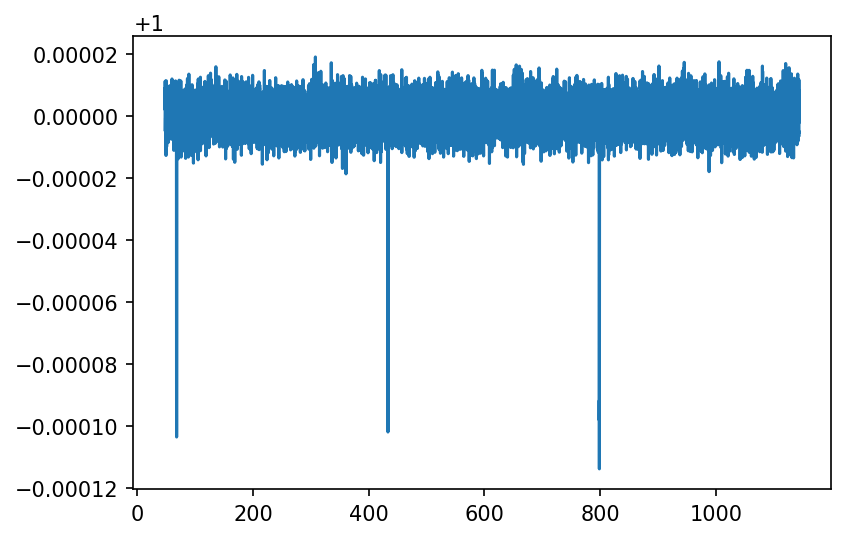

In [13]:
import matplotlib.pyplot as plt
from matplotlib import rcParams; rcParams["figure.dpi"] = 150
plt.plot(t, y);

Now, we run TLS and examine the signal detection efficiency:

In [14]:
from transitleastsquares import transitleastsquares
model = transitleastsquares(t, y)
results = model.power(
    period_min=300,
    period_max=400,
    oversampling_factor=3,
    duration_grid_step=1.05,
    T0_fit_margin=0.2
)
print('SDE with uniform noise', format(results.SDE, '.5f'))

Transit Least Squares TLS 1.0.16 (29 January 2019)
Creating model cache for 39 durations
Searching 13149 data points, 1781 periods from 300.025 to 399.939 days
Using all 8 CPU threads


100%|██████████| 1781/1781 periods | 00:04<00:00
  8%|▊         | 438/5716 [00:00<00:01, 4379.58it/s]

Searching for best T0 for period 365.22219 days


100%|██████████| 5716/5716 [00:01<00:00, 4652.87it/s]


SDE with uniform noise 17.25588


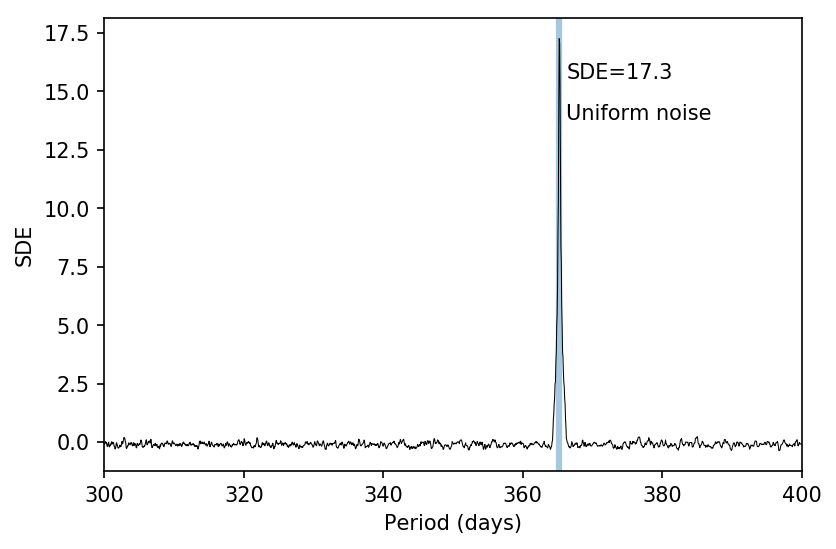

In [15]:
plt.figure()
ax = plt.gca()
ax.axvline(results.period, alpha=0.4, lw=3)
plt.xlim(numpy.min(results.periods), numpy.max(results.periods))
for n in range(2, 10):
    ax.axvline(n*results.period, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(results.period / n, alpha=0.4, lw=1, linestyle="dashed")
plt.ylabel(r'SDE')
plt.xlabel('Period (days)')
plt.plot(results.periods, results.power, color='black', lw=0.5)
plt.text(results.period + 1, results.SDE * 0.9, 'SDE=' + format(results.SDE, '.1f'))
plt.text(results.period + 1, results.SDE * 0.8, 'Uniform noise')
plt.xlim(300, 400);

Next, we modify the noise levels so that there is much more noise towards the end of the time series, where no transit occurs:

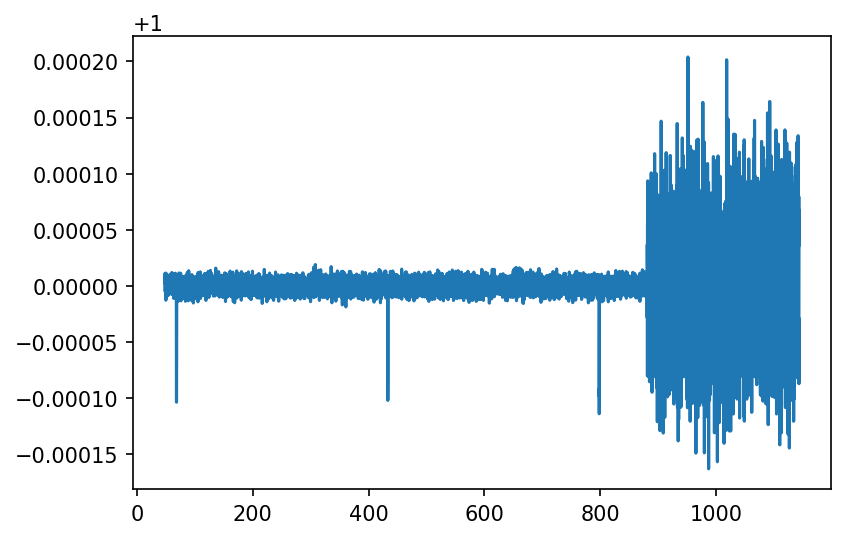

In [16]:
noise = numpy.random.normal(0, 10*stdev, 3149)
y[10000:] = y[10000:] + noise

dy = numpy.full(len(y),stdev)
dy[10000:] = 10*stdev
plt.plot(t, y);

We re-run TLS with identical settings, i.e.: not accounting for non-uniform noise:

Transit Least Squares TLS 1.0.16 (29 January 2019)
Creating model cache for 39 durations
Searching 13149 data points, 1781 periods from 300.025 to 399.939 days
Using all 8 CPU threads


100%|██████████| 1781/1781 periods | 00:04<00:00
 16%|█▌        | 909/5716 [00:00<00:01, 4479.62it/s]

Searching for best T0 for period 365.22219 days


100%|██████████| 5716/5716 [00:01<00:00, 4699.79it/s]


SDE non uniform noise, no uncertainties used:  14.36522


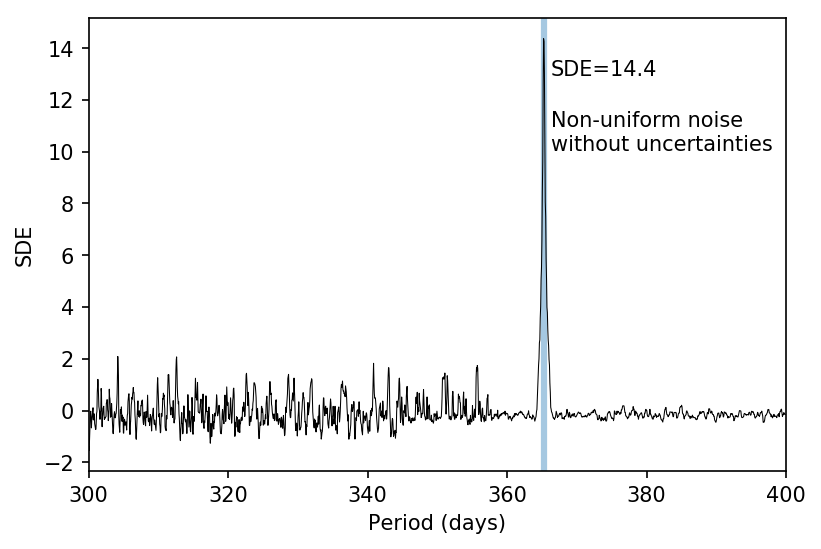

In [17]:
from transitleastsquares import transitleastsquares
model = transitleastsquares(t, y)
results = model.power(
    period_min=300,
    period_max=400,
    oversampling_factor=3,
    duration_grid_step=1.05,
    T0_fit_margin=0.2
)
print('SDE non uniform noise, no uncertainties used: ', format(results.SDE, '.5f'))

plt.figure()
ax = plt.gca()
ax.axvline(results.period, alpha=0.4, lw=3)
plt.xlim(numpy.min(results.periods), numpy.max(results.periods))
for n in range(2, 10):
    ax.axvline(n*results.period, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(results.period / n, alpha=0.4, lw=1, linestyle="dashed")
plt.ylabel(r'SDE')
plt.xlabel('Period (days)')
plt.plot(results.periods, results.power, color='black', lw=0.5)
plt.text(results.period + 1, results.SDE * 0.9, 'SDE=' + format(results.SDE, '.1f'))
plt.text(results.period + 1, results.SDE * 0.7, 'Non-uniform noise\nwithout uncertainties')
plt.xlim(300, 400);

The signal detection efficiency has decreased from 17.3 to 14.4, and additional noise is visible towards the shorter periods in the SDE-ogram (to explain this is left as an exercise to the reader).

Finally, we re-run TLS *with* correctly estimated measurement uncertainties:

Transit Least Squares TLS 1.0.16 (29 January 2019)
Creating model cache for 39 durations
Searching 13149 data points, 1781 periods from 300.025 to 399.939 days
Using all 8 CPU threads


100%|██████████| 1781/1781 periods | 00:04<00:00
  8%|▊         | 434/5716 [00:00<00:01, 4333.52it/s]

Searching for best T0 for period 365.22219 days


100%|██████████| 5716/5716 [00:01<00:00, 4709.96it/s]


SDE non uniform noise, uncertainties used:  17.23614


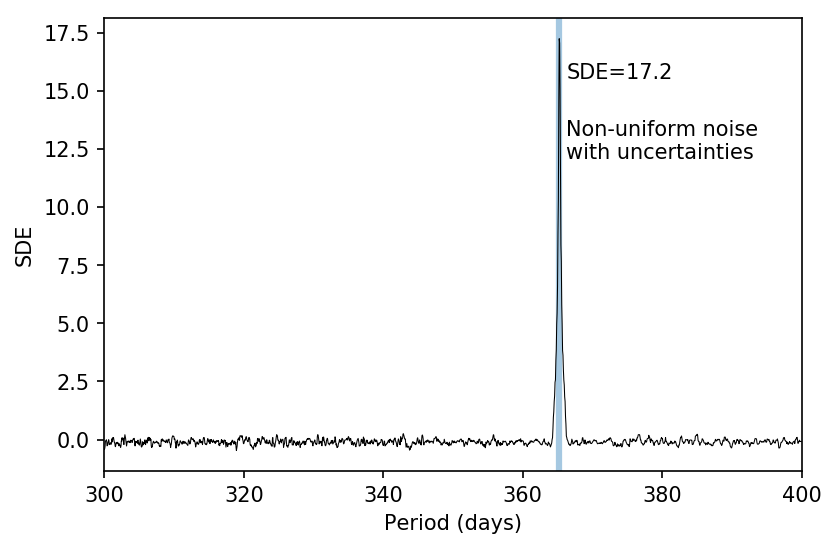

In [18]:
from transitleastsquares import transitleastsquares
model = transitleastsquares(t, y, dy)  # <== Here, the uncertainties are added
results = model.power(
    period_min=300,
    period_max=400,
    oversampling_factor=3,
    duration_grid_step=1.05,
    T0_fit_margin=0.2
)
print('SDE non uniform noise, uncertainties used: ', format(results.SDE, '.5f'))

plt.figure()
ax = plt.gca()
ax.axvline(results.period, alpha=0.4, lw=3)
plt.xlim(numpy.min(results.periods), numpy.max(results.periods))
for n in range(2, 10):
    ax.axvline(n*results.period, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(results.period / n, alpha=0.4, lw=1, linestyle="dashed")
plt.ylabel(r'SDE')
plt.xlabel('Period (days)')
plt.plot(results.periods, results.power, color='black', lw=0.5)
plt.text(results.period + 1, results.SDE * 0.9, 'SDE=' + format(results.SDE, '.1f'))
plt.text(results.period + 1, results.SDE * 0.7, 'Non-uniform noise\nwith uncertainties')
plt.xlim(300, 400);

To summarize, the results are:
- 17.3 SDE with uniform noise
- 14.4 SDE with non-uniform noise, searching with the uniform noise assumption
- 17.2 SDE with non-uniform noise, searching with correct uncertainties.

Very clearly, the use of measurement uncertainties, where available, is beneficial.